## Import Packages

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## Load Data

In [21]:
cleaned_df = pd.read_csv("cleaned_atp_data.csv", index_col=0)
cleaned_df.head()

,name,opp_name,tourney_date,grand_slam,best_of,surface,age,opp_age,seed_diff,rank_points_diff,...,avg_df,avg_svpt,avg_FirstIn,avg_FirstWon,avg_SecondWon,avg_SvGms,avg_bpSaved,avg_bpFaced,h2h_fantasy_pts,fantasy_pts
12,Todd Woodbridge,Jiri Novak,19961230,0,3,Hard,25.7,21.7,-46.0,209.0,...,6.0,90.0,53.0,40.0,20.0,14.0,4.0,5.0,14.50,20.0
13,Alex Obrien,Thomas Johansson,19961230,0,3,Hard,26.8,21.7,-45.0,237.0,...,1.0,115.0,75.0,59.0,25.0,17.0,4.0,5.0,21.00,16.0
14,Jeff Tarango,David Prinosil,19961230,0,3,Hard,28.1,23.8,44.0,-541.0,...,3.0,52.0,33.0,24.0,12.0,9.0,1.0,2.0,21.00,22.5
17,Mikael Tillstrom,Andrei Cherkasov,19961230,0,3,Hard,24.8,26.4,0.0,536.0,...,0.0,51.0,29.0,21.0,13.0,8.0,2.0,2.0,25.00,24.0
18,Todd Woodbridge,Alex Obrien,19961230,0,3,Hard,25.7,26.8,-1.0,39.0,...,4.0,90.0,56.0,40.5,16.0,12.5,4.0,5.5,17.25,19.5


## Preprocess Data

In [23]:
# Save numeric variables (and surface)
num_vars = [
    'grand_slam', 'best_of', 'surface', # Tourney vars
    'age', 'opp_age', 'seed_diff', 'rank_points_diff', # Player vars
    'avg_fantasy_pts', 'avg_ace', 'avg_df', 'avg_svpt', 'avg_FirstIn', # Stat avgs
    'avg_FirstWon', 'avg_SecondWon', 'avg_SvGms', 'avg_bpSaved', 'avg_bpFaced', # Stat avgs
    'h2h_fantasy_pts', # H2H avgs
    'fantasy_pts'] # Response var
cleaned_df = cleaned_df[num_vars]

# Create dummy variables for surface
model_df = pd.get_dummies(data=cleaned_df, columns=['surface'])

## Train-Test Split

In [24]:
# Separate predictor and response variables
X = model_df.drop(['fantasy_pts'], axis = 1)
y = model_df['fantasy_pts']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Modeling

### Simple Linear Regression

In [25]:
# Fit and predict a linear model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)

# Print train and test statistics
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.22536938518012495
Train MSE: 56.02382057581777

Test R-Squared: 0.21402223642107365
Test MSE: 56.9315437999134


### Lasso Regression

In [28]:
# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=1, max_iter=10000)

# Fit these models and record accuracy
model.fit(X_train, y_train)

# Run lasso on the best alpha value
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)
y_train_pred = lasso_best.predict(X_train)
y_pred = lasso_best.predict(X_test)

# Print train and test statistics
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: -0.3483029379432192
Train MSE: 63.518898656277955

Test R-Squared: -0.35999817720041905
Test MSE: 63.80931043584518


### Decision Tree Regressor

In [30]:
# Grid search for best parameters
parameters = {'max_depth': [2,4,6,8,10,12],
             'min_samples_split': [2,3,4],
             'min_samples_leaf': [1,2]}
tree = DecisionTreeRegressor()
gscv = GridSearchCV(estimator=tree,param_grid=parameters)
gscv.fit(X_train, y_train)

# Fit model with the best parameters
model = gscv.best_estimator_
model.fit(X_train, y_train)

# Print train and test statistics
y_train_pred = model.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
y_pred = model.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.7275426537929284
Train MSE: 27.481556307514158

Test R-Squared: 0.6420062151618307
Test MSE: 36.09630353488186


### Random Forest Regressor

In [31]:
# Fit a random forest and predict
rfor = RandomForestRegressor(max_depth=19, max_features=1.0)
rfor.fit(X_train, y_train)


# Print train and test statistics
y_train_pred = rfor.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()
y_pred = rfor.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.910443662265121
Train MSE: 9.561530684997651

Test R-Squared: 0.7249990704216469
Test MSE: 26.974958740273102


## Model Selection Prediction

It is clear that the random forest regressor performs the best, so we will select this model and perform additional analysis.

*Mean-absolute-error of 3.86 fantasy points is a very satisfying result, as the standard deviation of results is 11.32 points. Decent performance can be achieved by selecting a set number of points for the predicted winner and a set number of points for the predicted loser, but this model performs better than that. MAE is probably more relevant than MSE because we do not care about penalizing based on how inaccurate predictions are; we are just predicting if the value does or does not exceed the over/under line set by PrizePicks.

Test R-Squared: 0.7249990704216469
Test MSE: 26.974958740273102
Test MAE: 3.8609312122291612


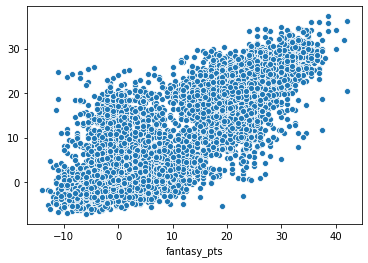

In [32]:
# Random forest regressor analysis
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))
print("Test MAE:", mean_absolute_error(y_pred, y_test))
sns.scatterplot(x = y_test, y = y_pred)